# Model Building

Use the original login data combined with the attack model probability score to build a risk model

In [31]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import seaborn as sns
import imblearn 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
LOGINS_FILENAME = '../data/rba-dataset.csv' # downloaded from kaggle site
SAMPLED_IPS_FILENAME = './attack_preds.csv'

In [4]:
df_logins = dd.read_csv(LOGINS_FILENAME) 
df_ips = pd.read_csv(SAMPLED_IPS_FILENAME)

In [5]:
# Our data will be a "sample" of all logins based on 30% of all IP addresses
df_sample = df_logins[df_logins['IP Address'].isin(df_ips['IP Address'])].compute() 

In [6]:
df_sample.columns

Index(['index', 'Login Timestamp', 'User ID', 'Round-Trip Time [ms]',
       'IP Address', 'Country', 'Region', 'City', 'ASN', 'User Agent String',
       'Browser Name and Version', 'OS Name and Version', 'Device Type',
       'Login Successful', 'Is Attack IP', 'Is Account Takeover'],
      dtype='object')

In [7]:
df_sample.shape

(22316836, 16)

In [8]:
# Add features for yes/no Norway and one-hot of the device type
df_sample['login_timestamp_dttm'] = pd.to_datetime(df_sample['Login Timestamp'])
df_sample['hour_of_day'] = df_sample['login_timestamp_dttm'].dt.hour
df_sample['is_norway'] = df_sample['Country'] == 'NO'
df_sample['Device Type'] = df_sample['Device Type'].fillna('desktop')
df_sample = pd.concat([df_sample, pd.get_dummies(df_sample['Device Type'])], axis=1)

In [9]:
# Add features for each user with % login success 
df_sample['logins_hour_of_day_total'] = 1
df_sample['Login Successful'] = df_sample['Login Successful'].fillna(0)
df_sample['Login Successful Int'] = df_sample['Login Successful'].astype(int)
df_users = df_sample.groupby(['User ID', 'hour_of_day'])[['Login Successful Int', 'logins_hour_of_day_total']].sum().reset_index()
df_users['logins_hpd_accuracy'] = df_users['Login Successful Int'] / df_users['logins_hour_of_day_total']
df_sample.drop(columns=['Login Successful Int', 'logins_hour_of_day_total'], inplace=True)
df_users.head() 

,User ID,hour_of_day,Login Successful Int,logins_hour_of_day_total,logins_hpd_accuracy
0,-9223369089733265380,12,0,1,0.000000
1,-9223358650992576877,22,1,1,1.000000
2,-9223352587108731553,16,0,1,0.000000
3,-9223351024921207274,22,2,3,0.666667
4,-9223350146673567063,8,1,1,1.000000


In [10]:
# Build complete feature set with user data and login data
df_features = df_sample.merge(df_users, on=['User ID', 'hour_of_day'])
df_features = df_features.merge(df_ips[['IP Address', 'attack_probability']], on='IP Address')

In [29]:
df_features.columns

Index(['index', 'Login Timestamp', 'User ID', 'Round-Trip Time [ms]',
       'IP Address', 'Country', 'Region', 'City', 'ASN', 'User Agent String',
       'Browser Name and Version', 'OS Name and Version', 'Device Type',
       'Login Successful', 'Is Attack IP', 'Is Account Takeover',
       'login_timestamp_dttm', 'hour_of_day', 'is_norway', 'bot', 'desktop',
       'mobile', 'tablet', 'unknown', 'Login Successful Int',
       'logins_hour_of_day_total', 'logins_hpd_accuracy', 'attack_probability',
       'count'],
      dtype='object')

<AxesSubplot:xlabel='Device Type', ylabel='count'>

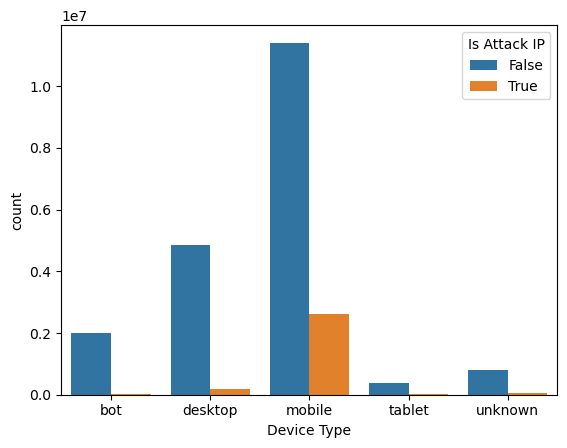

In [11]:
# Quick visual for the presentation 
df_features['count'] = 1
test = df_features.groupby(['Is Attack IP', 'Device Type'])['count'].sum().reset_index()
sns.barplot(x='Device Type', y='count', hue='Is Attack IP', data=test)

## Oversampling

We will use oversampling to generate 30% positive results of account takeovers. We can tune the 30% if we want, but it seems like a good number to start with. 

In [39]:
X = df_features[['hour_of_day', 'is_norway', 'bot', 'desktop', 'mobile', 'tablet',
       'unknown', 'Login Successful Int', 'logins_hour_of_day_total',
       'logins_hpd_accuracy', 'attack_probability']]
y = df_features['Is Account Takeover']

smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.3)

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', y.value_counts())
print('Resample dataset shape', y_smote.value_counts())

Original dataset shape False    22316695
True          141
Name: Is Account Takeover, dtype: int64
Resample dataset shape False    22316695
True      6695008
Name: Is Account Takeover, dtype: int64


## Model Building 

### First, let's experiment with different models using a single train/test split 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.5, random_state=0)

In [41]:
dtc = DecisionTreeClassifier()
y_pred = dtc.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 14505852 points : 20193


In [46]:
pred_proba = gbdt_clf.predict_proba(X_test)

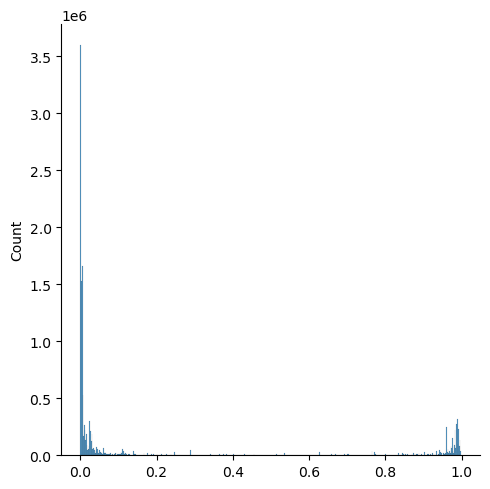

In [47]:
sns.displot(pred_proba[:,1])

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
accuracy_score(y_test, y_pred)

0.9857383075464992

In [26]:
nc = NearestCentroid()
y_pred = nc.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 14505852 points : 5656039


In [37]:
gbdt_clf = GradientBoostingClassifier()
y_pred = gbdt_clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 14505852 points : 281596


In [ ]:
# TODO: Try more models. Do hyperparameter tuning. Complete 10-fold cross val on final model. 

## The same model without the attack prediction score 

This might help show if the model was better or worse with the attack IP prediction score over the 0/1 indicator for attack IPs

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X = df_features[['hour_of_day', 'is_norway', 'bot', 'desktop', 'mobile', 'tablet',
       'unknown', 'Login Successful Int', 'logins_hour_of_day_total',
       'logins_hpd_accuracy', 'Is Attack IP']] # use the original Is Attack IP column
y = df_features['Is Account Takeover']

import imblearn 
smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.3)

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.5, random_state=0)
dtc = DecisionTreeClassifier()
y_pred = dtc.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 14505852 points : 206543


In [34]:
gbdt_clf = GradientBoostingClassifier()
y_pred = gbdt_clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 14505852 points : 328130


## Potential code for later...

In [15]:
# TBD: Maybe add more a window lag over for logins by a user

# df_features['login_timestamp_dttm'] = pd.to_datetime(df_features['Login Timestamp'])
# df_window = df_features.sort_values('login_timestamp_dttm')
# df_window = df_window.groupby(['User ID'])
# df_window['Time Since Last Attempt'] = df_window['login_timestamp_dttm'].rolling(window=2).apply(lambda x: x.iloc[-1] - x.iloc[0])
# df_window = df_window.reset_index() 
# df_window.head() 